## Import relevant libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

1. "torchvision" is a package in PyTorch specifically designed to provide access to datasets, model architectures and image transformation functionalities for computer vision tasks
2. torchvision contains popular datasets and since we are interested in working with sample images from the popular MNIST dataset, we are importing datasets from the torchvision package
3. While working with images, the "raw data" is in the format of PIL (Python Imaging Library) images and it is common practice to convert the images to PyTorch tensors so that we can use them in the NN framework. Therefore, we are importing transforms

## Load the MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

The above line converts the "raw data" in the format of PIL to PyTorch tensors by passing "transforms.ToTensor()" to "transforms.Compose()"

In [3]:
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

1. The MNIST data that we will be working with might not be available on our local computers, the first time we work with them
2. Therefore, we might need to download the MNIST data
3. We might also run into a situation, where the MNIST data was downloaded previously but goes missing for some reason
4. By setting the "download" flag to "True", we are just ensuring that the MNIST data will be downloaded and made available to us in our local directory and scenarios we might require this is for example, the first time we are working with the data
5. By setting the "train" flag to "True", we are just letting PyTorch know that we are interested in working the "training data" from the MNIST dataset
6. The "root = './data" part tells PyTorch to look for the MNIST data in a directory named "data". PyTorch will download data to the "data" directory, in case no MNIST data is available
7. Note that "data" is a "sub-directory" of our working directory where Jupyter notebook is currently located
8. The "transforms" part tells PyTorch about the "transformations" that we are interested in carrying out
9. Finally, all of the desired settings are passed to "datasets.MNIST" to "instantiate" an object of the MNIST dataset with the desired characteristics
10. Note that instantiating an object of the class "datasets.MNIST" with the desired characteristics does NOT generate the desired the MNIST data but merely sets up the stage or creates the configurations required to actually generate the desired MNIST data. We need to use the in-built PyTorch DataLoader module with these "desired configurations" to actually get our MNIST data
11. In summary, "datsets.MNIST" prepares the data and "DataLoader" actually fetches the data
12. We will use PyTorch's "DataLoader" next

In [4]:
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=64, shuffle=True)

1. The above line of code creates a data loader in PyTorch for the MNIST dataset
2. We have set "batch_size = 1" since we are interested in loading a single image
3. We have set "shuffle = True" as this is just common practice. It might not be strictky required for our problem

## Extracting one image from the dataset

Extracting the first image from the first batch

In [5]:
sample_image = next(iter(data_loader))[0][0]

## Understanding the type and shape of the sample image

In [6]:
print(type(sample_image), sample_image.shape)
print(type(sample_image.squeeze()), sample_image.squeeze().shape)
print(type(sample_image.squeeze().numpy()), sample_image.squeeze().numpy().shape)

<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'torch.Tensor'> torch.Size([28, 28])
<class 'numpy.ndarray'> (28, 28)


1. Our sample image is a "torch tensor" and printing the shape tells us that it has redundant dimensions
2. The .squeeze() operation removes the redundant dimenions and the type remains a torch tensor
3. The .numpy() operation converts the image into a numpy array from a torch tensor
4. We are converting the image into a numpy array as many visualization libraries work well with numpy

## Convert image to numpy array for display

In [7]:
sample_image_plot = sample_image.squeeze().numpy()

## Display sample image

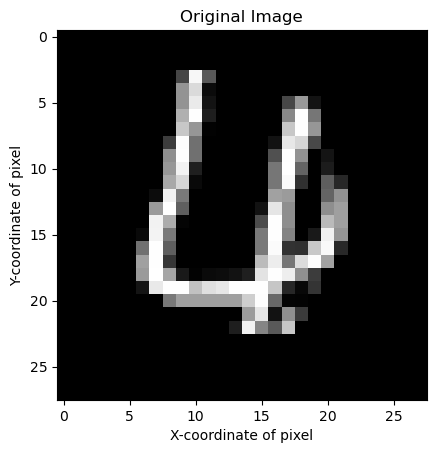

In [8]:
plt.figure()
plt.imshow(sample_image_plot, cmap='gray')
plt.xlabel('X-coordinate of pixel')
plt.ylabel('Y-coordinate of pixel')
plt.title('Original Image')
plt.show()

## Define the PSF as a 2D Gaussian

1. Note that the choices of the parameters used in the PSF are arbitrary
2. Future work should considering linking the PSF parameters to the optical characteristics of the system in question
3. Here, we are just trying to demonstrate the idea of using "Physics-based" layers in a Neural Network framework to mimic the behavior of the microscope

In [9]:
sigma = 1.0
PSF_size = 15
PSF = torch.zeros(PSF_size, PSF_size)
PSF_center = PSF_size // 2
for x in range(PSF_size):
    for y in range(PSF_size):
        PSF[x, y] = torch.exp(torch.tensor(-((x - PSF_center) ** 2 + (y - PSF_center) ** 2) / (2 * sigma ** 2)))

## Normalize the PSF

In [10]:
PSF /= PSF.sum()

## Visualize the PSF

C:\ProgramData\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


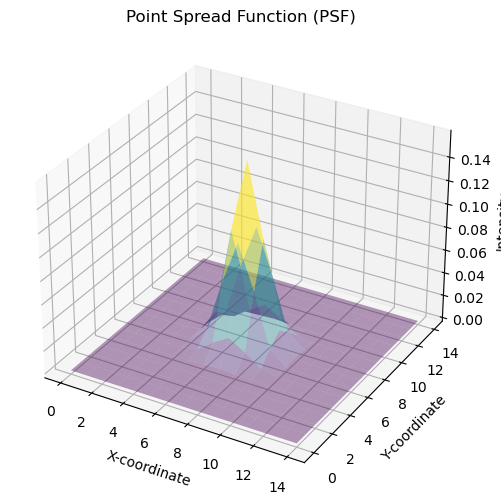

In [11]:
PSF_plot = PSF.numpy()

x = torch.arange(PSF_size)
y = torch.arange(PSF_size)
x, y = torch.meshgrid(x, y)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, PSF_plot, cmap='viridis', alpha=0.4)

ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Intensity')
ax.set_title('Point Spread Function (PSF)')

plt.show()

## Create the custom Microscope CNN Layer

In [12]:
class MicroscopeCNNLayer(nn.Module):
    def __init__(self, psf_kernel):
        super().__init__()
        self.conv_layer = nn.Conv2d(1, 1, kernel_size=psf_kernel.size(0), padding='same', bias=False)
        self.conv_layer.weight = nn.Parameter(psf_kernel.unsqueeze(0).unsqueeze(0), requires_grad=False)
        self.intensity_layer = IntensityLayer()
        self.downsampling_layer = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        output_conv = self.conv_layer(x)
        output_intensity = self.intensity_layer(output_conv)
        output_final = self.downsampling_layer(output_intensity)
        return output_conv, output_intensity, output_final

In [13]:
class IntensityLayer(nn.Module):
    def forward(self, x):
        return torch.square(torch.abs(x))

1. The "nn.Conv2d" initializes a 2D convolution layer
2. The "1, 1" inputs to "nn.Conv2d" represent the number of input and output channels respectively, which in our case is one, since channel does not really have any "meaning" for our problem at this stage
3. The kernel size is determined by the size of the point spread function (PSF). Since our PSF is a square matrix, we can choose the size of either dimension and make the arbitrary choice of using the first element indexed by zero, as it is a redundant choice
4. Since our input and output is of the same size, we set padding = 'same". Note that for the Conv2D layer in PyTorch, this setting only works for a stride of unity
5. The default value of the stride parameter is unity and we have not changed it. Therefore, stride is unity for our problem and padding can be set to "same"
6. The "Microscope Layer" mimics the behavior of the microscope which represents the convolution between the PSF and the optical field emerging from the sample. Thus, the "bias" parameter never enters the picture
7. Since, the default value of the "bias" flag is "True" and since this parameter is not relevant for our problem, we have explicity set it to "False"
8. The weights of the CNN filter are equivalent to the values stoted in the PSF matrix for our problem
9. Thus, the PSF matrix values are identified as "physical weights" and these weights are special in the sense that they are assumed to be "trainable parameters" since they identify as weights but in reality they are "frozen" and not to be trained. The "requires_grad = False" ensures that these "physical weights" are frozen
10. The "psf_kernel.unsqueeze(0).unsqueeze(0)" is required to ensure that the "physical filter" has the "right dimensions" that are required of CNN filters used during computation
11. The "conv_layer" simply performs a convolution operation that mimics the behavior of the microscope lens on the optical field emerging from the sample
12. Following the action of the lens or the "conv_layer", the camera measures the downsampled intensity values of the optical field
13. The "intensity layer" is initialized using a custom class defined after the Microscope class. This layer basically performs a squaring of the absolute value of the optical field to extract an "intensity field"
14. Finally, the in-built PyTorch average pooling layer is used for downsampling
15. The forward pass executes convolution of the PSF with the optical field emerging from the sample, followed by an extraction of the incident field that is at the end, downsampled
16. Note that the choice of the Average Pooling Layer parameters was arbitrary, just like the choices of the parameters in the "conv_layer" or PSF weights

## Instantiate an object of the Microscope CNN Layer

In [14]:
microscope_layer = MicroscopeCNNLayer(PSF)

## Apply the sample image to the Microscope Layer

In [15]:
output_conv, output_intensity, output_final = microscope_layer(sample_image)

## Convert output image to numpy array for display

In [16]:
output_conv_image_plot = output_conv.squeeze().numpy()
output_intensity_image_plot = output_intensity.squeeze().numpy()
output_final_image_plot = output_final.squeeze().numpy()
output_image_plot = output_final_image_plot
input_image_plot = sample_image_plot

## Display output images

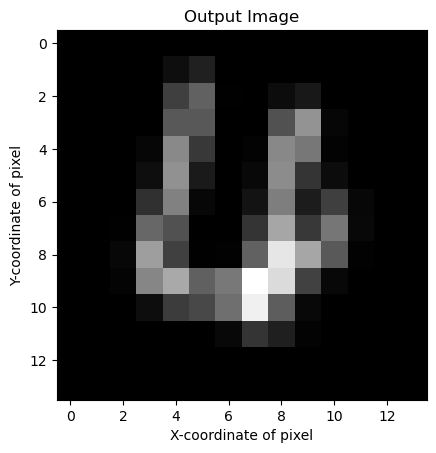

In [17]:
plt.figure()
plt.imshow(output_image_plot, cmap='gray')
plt.xlabel('X-coordinate of pixel')
plt.ylabel('Y-coordinate of pixel')
plt.title('Output Image')
plt.show()

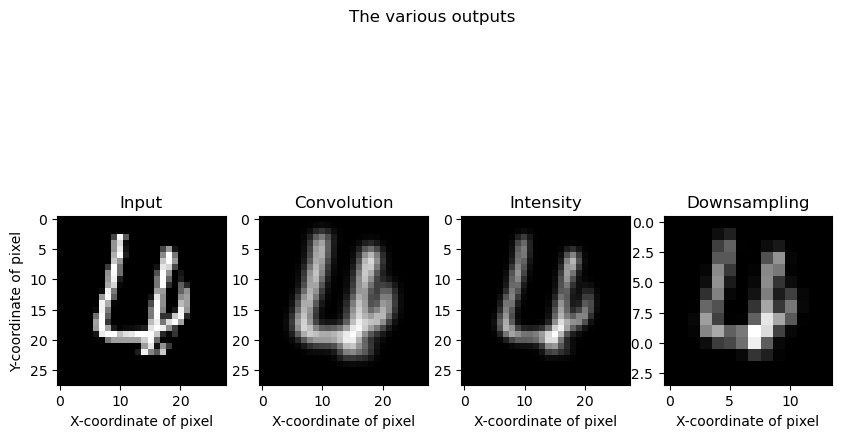

In [18]:
fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize=(10, 6))
fig.suptitle("The various outputs")

ax_1.imshow(input_image_plot, cmap='gray')
ax_1.set_xlabel('X-coordinate of pixel')
ax_1.set_ylabel('Y-coordinate of pixel')
ax_1.set_title('Input')

ax_2.imshow(output_conv_image_plot, cmap='gray')
ax_2.set_xlabel('X-coordinate of pixel')
ax_2.set_ylabel('Y-coordinate of pixel')
ax_2.set_title('Convolution')

ax_3.imshow(output_intensity_image_plot, cmap='gray')
ax_3.set_xlabel('X-coordinate of pixel')
ax_3.set_ylabel('Y-coordinate of pixel')
ax_3.set_title('Intensity')

ax_4.imshow(output_final_image_plot, cmap='gray')
ax_4.set_xlabel('X-coordinate of pixel')
ax_4.set_ylabel('Y-coordinate of pixel')
ax_4.set_title('Downsampling')

plt.show()

## Compare input and output images

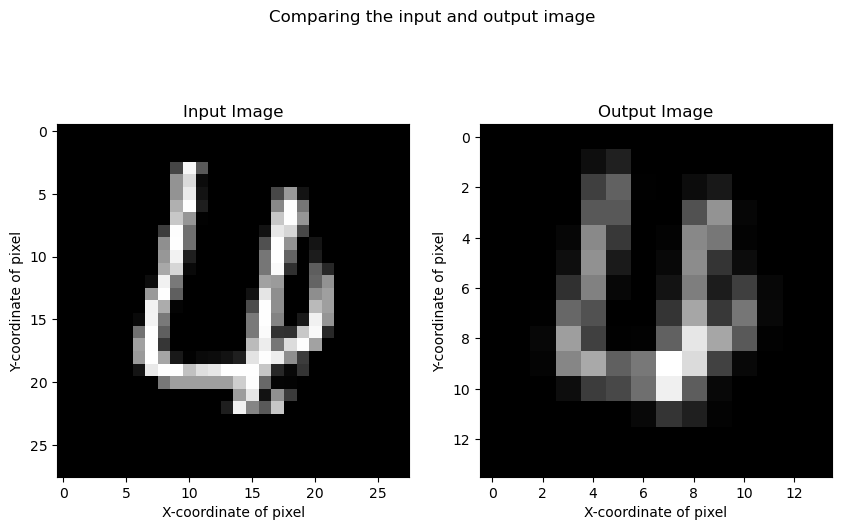

In [19]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle("Comparing the input and output image")

ax_1.imshow(input_image_plot, cmap='gray')
ax_1.set_xlabel('X-coordinate of pixel')
ax_1.set_ylabel('Y-coordinate of pixel')
ax_1.set_title('Input Image')

ax_2.imshow(output_image_plot, cmap='gray')
ax_2.set_xlabel('X-coordinate of pixel')
ax_2.set_ylabel('Y-coordinate of pixel')
ax_2.set_title('Output Image')

plt.show()